# 1. Data Generation

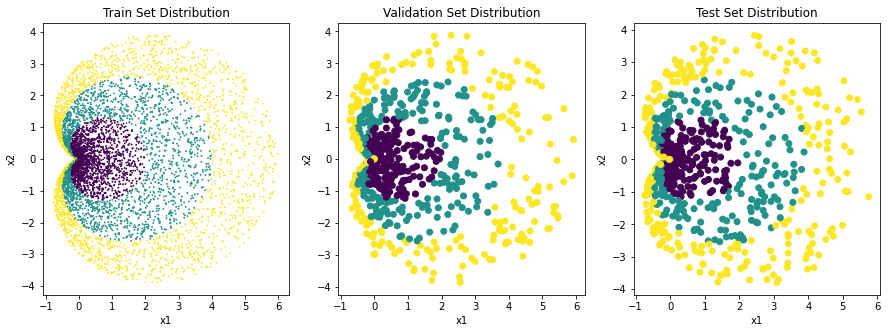

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


# ====== Generating Dataset ====== #
r = np.random.rand(10000)*3
theta = np.random.rand(10000)*2*np.pi
y = r.astype(int)
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')


ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()

# 2. Model Define

In [8]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

In [9]:
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# 3. Loss Function Define

In [4]:
cls_loss = nn.CrossEntropyLoss()

# crossentropy loss는 softmax를 포함하고 있음

# 4. Train & Evaluation

### Linear Model

9 parameters


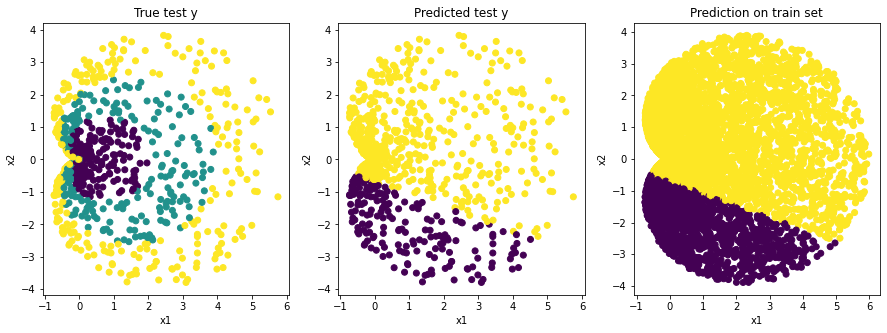

Epoch:  0 Accuracy:  26.0 %


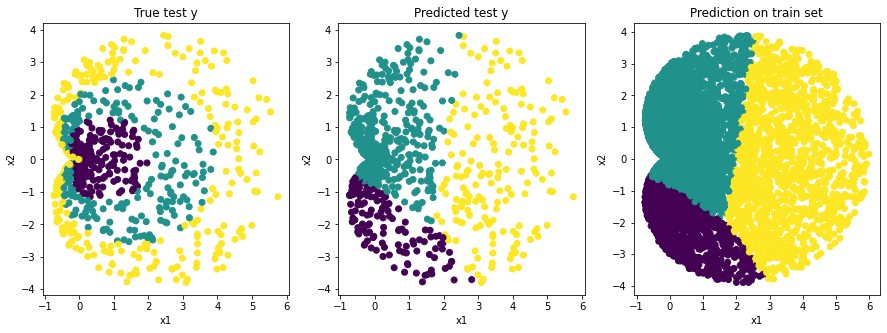

Epoch:  400 Accuracy:  29.799999999999997 %


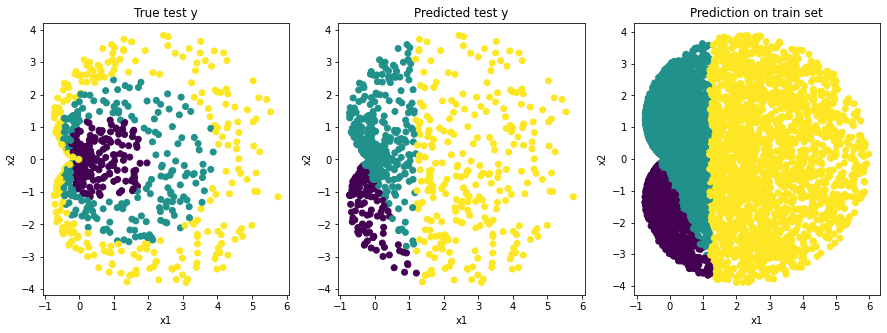

Epoch:  800 Accuracy:  30.5 %


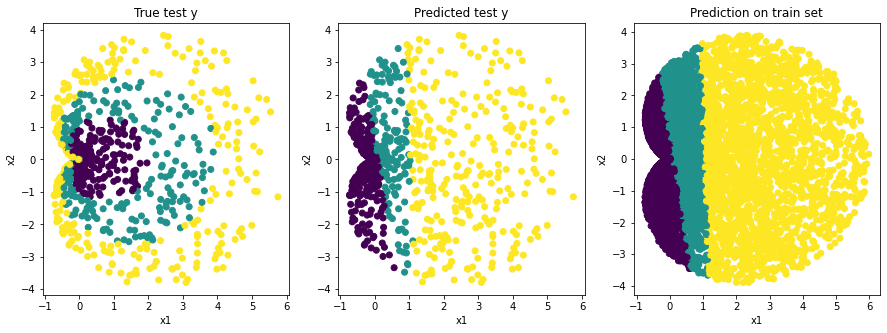

Epoch:  1200 Accuracy:  36.199999999999996 %


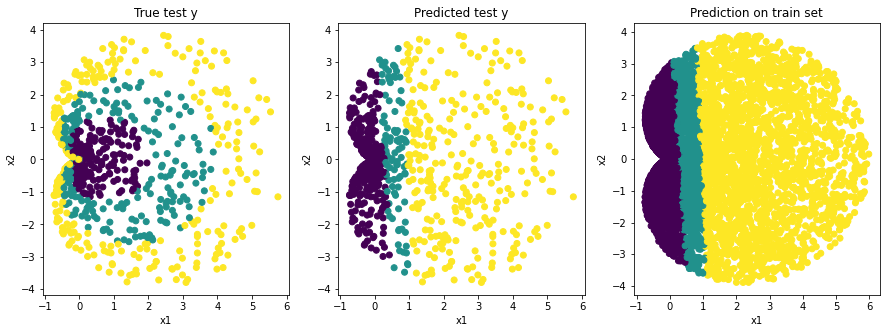

Epoch:  1600 Accuracy:  38.3 %


In [7]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

model = LinearModel() # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []


epoch = 2000 # 학습 횟수(epoch)을 지정해줍시다.
for i in range(epoch):
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long()
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)   
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 400 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate Accuracy ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        acc = accuracy_score(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_acc.append(acc)
        list_acc_epoch.append(i)

        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

### MLP Model

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1203 parameters


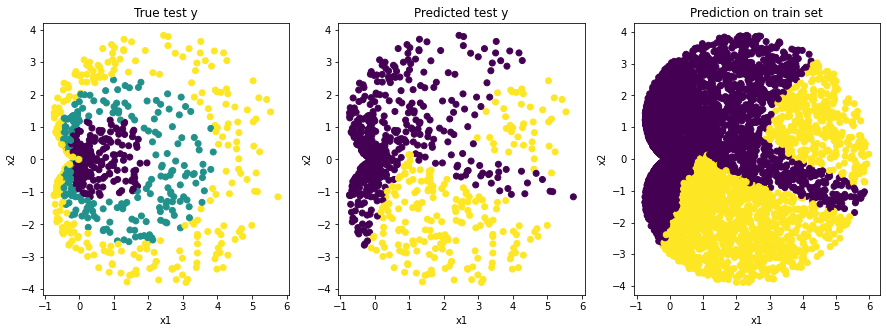

Epoch:  0 Accuracy:  35.3 %


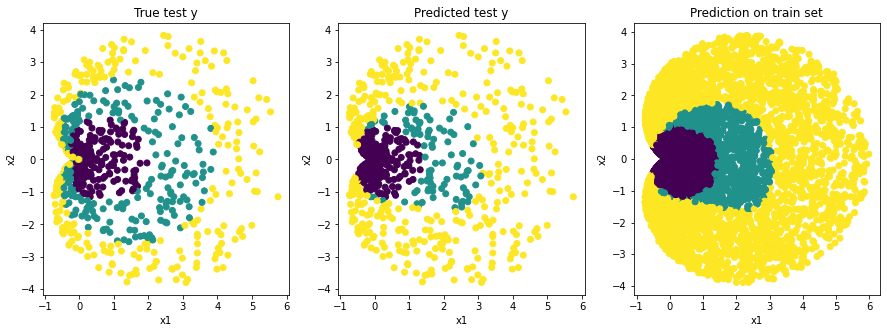

Epoch:  400 Accuracy:  61.3 %


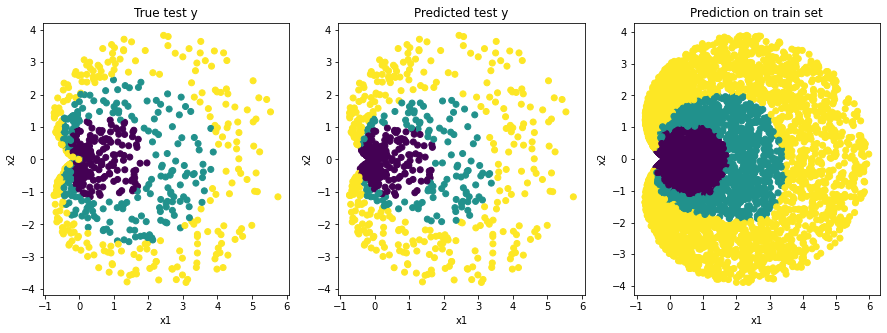

Epoch:  800 Accuracy:  67.80000000000001 %


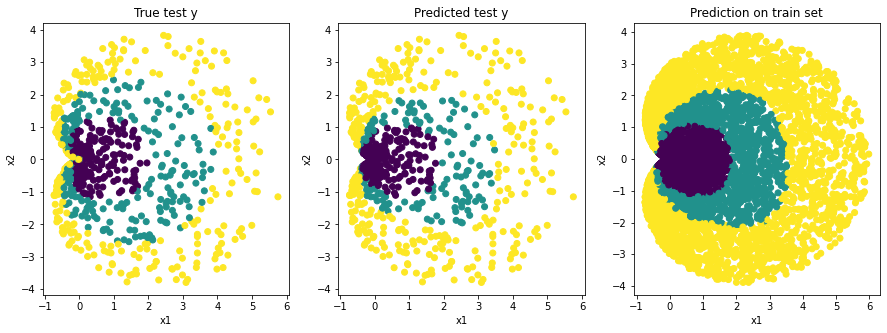

Epoch:  1200 Accuracy:  70.39999999999999 %


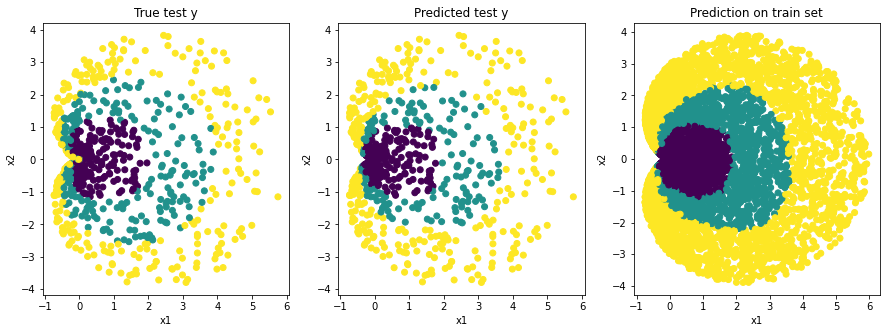

Epoch:  1600 Accuracy:  72.8 %


In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

model = MLPModel() # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

# ===== Construct Optimizer ====== #
lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []


epoch = 2000 # 학습 횟수(epoch)을 지정해줍시다.
for i in range(epoch):
    
    # ====== Train ====== #
    model.train() # model을 train 모드로 세팅합니다. 반대로 향후 모델을 평가할 때는 eval() 모드로 변경할 겁니다 (나중 실습에서 쓸 겁니다)
    optimizer.zero_grad() # optimizer에 남아있을 수도 있는 잔여 그라디언트를 0으로 다 초기화해줍니다.
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long()
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
    
    # ====== Validation ====== #
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)   
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

    # ====== Evaluation ======= #
    if i % 400 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
        # ====== Calculate Accuracy ====== #
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        acc = accuracy_score(true_y, pred_y) # sklearn 쪽 함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어가는 것에 주의합시다
        list_acc.append(acc)
        list_acc_epoch.append(i)

        fig = plt.figure(figsize=(15,5))
        
        # ====== True Y Scattering ====== #
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
        # ====== Predicted Y Scattering ====== #
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
        # ====== Just for Visualizaing with High Resolution ====== #
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

# 5. Report Experiment

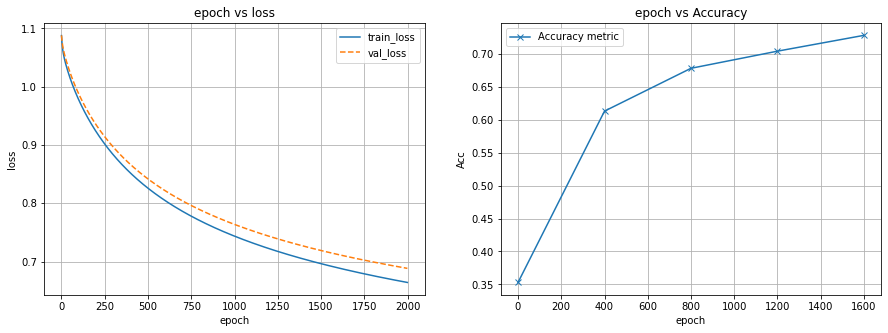

In [6]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()